In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm
import warnings
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
warnings.filterwarnings('ignore')
#한글 깨짐방지
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

C:\Users\User\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [2]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')
merge_df = pd.concat([train,test])

### 휴일

In [3]:
#전체날짜의 휴일 요일
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date','days_of_week','holyday']]
all_dates.reset_index(drop=True, inplace=True)
all_dates['date'] = pd.to_datetime(all_dates['date'])

In [4]:
holidays = all_dates[all_dates['holyday'] >0][['date','holyday']]
holidays.columns = ['ds','holiday']
holidays['lower_window'] = 0
holidays['upper_window'] = 0

holidays.holiday = holidays.holiday.astype('str')

## 전처리

In [5]:
#그냥 합산했을때 음수 발생하는 경우가 있음
d_sum = test.groupby(['date','store_id'])['amount'].sum().reset_index()
d_sum[d_sum['amount']<0].head()

,date,store_id,amount
83,2016-08-02,1,-2500
190,2016-08-03,57,-675
7243,2016-10-21,129,-40
8576,2016-11-04,135,-9071
9958,2016-11-19,67,-1138


In [6]:
def del_minus(df):
    '''음수값을 처리하기 위함
    음수값을 처리할때 조건은, 동일 store_id, card_id이어야하며
    날짜는 minus보다 이전 날짜
    금액은 minus보다 큰 금액이어야 함

    위 조건을 만족하는 row가 여러개일 경우
    가장 최근의 날짜를 선택하되, 그 날짜가 이미 선택되어 있다면
    보다 이전날짜를 탐색하고, matching되지 않는다면 따로 분류

    속도를 원활하게 하기 위해 diction에 저장후 plus_amount_df와 매칭
    '''
    df['DT'] = pd.to_datetime(df['date']+" "+df['time'])
    minus_amount_df = df[df.amount<0][['DT','store_id','card_id','amount']]
    plus_amount_df = df[df.amount>0][['DT','store_id','card_id','amount']]

    err_dic = dict()
    not_match = []
    check_list = []
    err_dic[470565] = 0
    for i in tqdm(range(minus_amount_df.shape[0])):
        error_index = np.nan #초기화
        minus_index = minus_amount_df.iloc[i].name
        minus_card = minus_amount_df.iloc[i].card_id 
        minus_store = minus_amount_df.iloc[i].store_id
        minus_DT = minus_amount_df.iloc[i].DT
        minus_amount = minus_amount_df.iloc[i].amount

        try :
            range_df = plus_amount_df[plus_amount_df.store_id == minus_store] #동일 상점
            range_df = range_df[range_df.card_id == minus_card] #동일 카드
            range_df = range_df[range_df.DT <= minus_DT] #이전날짜
            range_df = range_df[range_df.amount.apply(lambda x : x >= abs(minus_amount))] #보다 큰 금액
            big_df = range_df[range_df.amount.apply(lambda x : x > abs(minus_amount))] #보다 큰 금액
            same_df = range_df[range_df.amount.apply(lambda x : x == abs(minus_amount))] #동일한 금액
        except :
            not_match.append(minus_index)
            pass

        #동일한 금액이 있는 경우
        if len(same_df)>=1:
            same_index = same_df.index
            error_index = same_index.max()  #최근날짜의 index를 추출
            if error_index in err_dic.keys(): #그 index가 이미 key값을 가지고 있는지 확인
                same_index = list(same_index)
                same_index.reverse()
                for dex in same_index[1:]: 
                    error_index = dex
                    if error_index not in err_dic.keys(): #key에 없는 값을 찾았다면 중단
                        break
                if error_index in err_dic.keys(): #모든 인덱스를 비교하고도 key값에 있다면 not_match에 저장
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass

        #금액보다 더 큰 금액
        elif len(big_df)>= 1:
            big_index = big_df.index
            error_index = big_index.max()
            if error_index in err_dic.keys():
                big_index = list(big_index)
                big_index.reverse()
                for dex in big_index[1:]:
                    error_index = dex
                    if error_index not in err_dic.keys(): 
                        break
                if error_index in err_dic.keys():
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass
        else : 
            not_match.append(minus_index) #매칭되는 것이 없다면 not_match에 넣어둔다 

    #최종정리
    plus_amount_df = df[df.amount>0]
    fin_minus= pd.DataFrame(index= err_dic.keys(),data=err_dic.values(), columns= ['minus']) 
    plus_amount_df = pd.merge(plus_amount_df,fin_minus,left_index=True, right_index=True,how = 'left')
    plus_amount_df['minus'].fillna(0,inplace = True)
    plus_amount_df['amount'] = plus_amount_df['amount'] + plus_amount_df['minus']
    plus_amount_df.drop('minus',axis=1,inplace=True)        
    return plus_amount_df

In [7]:
new_test = del_minus(test)
# new_train = del_minus(train)

### 아웃라이어제거

In [13]:
# #상위 5개 값을 제거한다,이렇게함으로써 아웃라이어제거가능
# def del_top5(df):
#     all_top5 = []
#     for i in tqdm(df.store_id.unique()):
#         top5 = list(df[df.store_id == i].amount.sort_values(ascending=False).head(5).index)
#         all_top5.append(top5)

#     del_index = [y for x in all_top5 for y in x]
#     df = df.loc[~(df.index.isin(del_index))]
    
#     return df

# new_test = del_top5(new_test)

### fbprophet적용
* 기초적용

In [8]:
train_grouped = new_test.groupby(['date','store_id'])['amount'].sum().reset_index()

In [9]:
train_grouped.store_id.nunique()

200

### 각 store_id별로 적용후 rmse 비교

In [11]:
Train = False

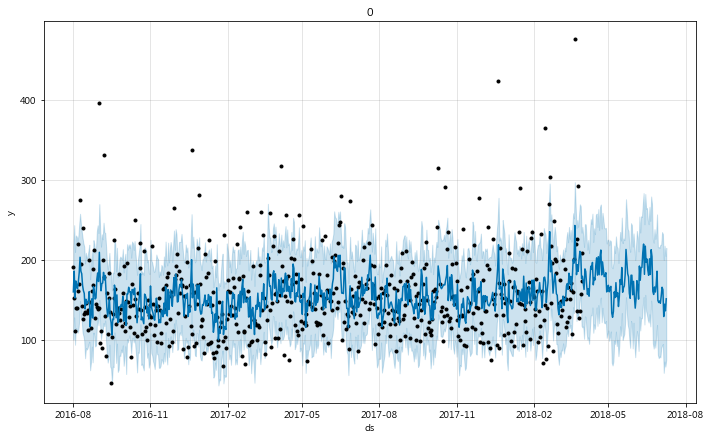

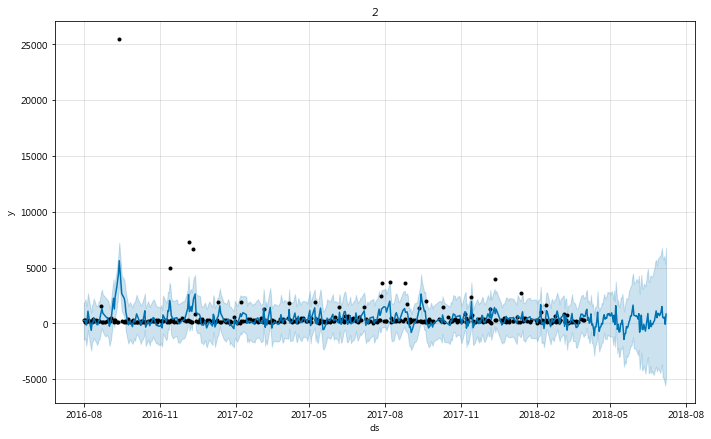

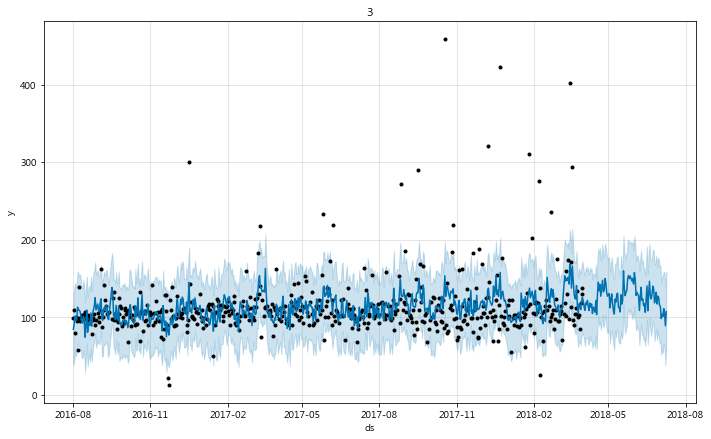

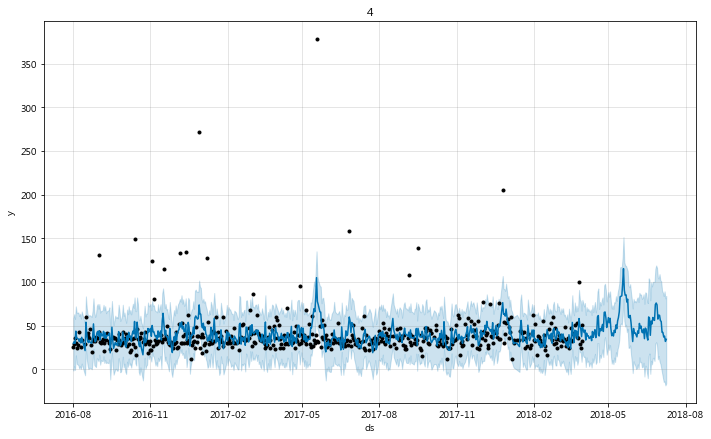

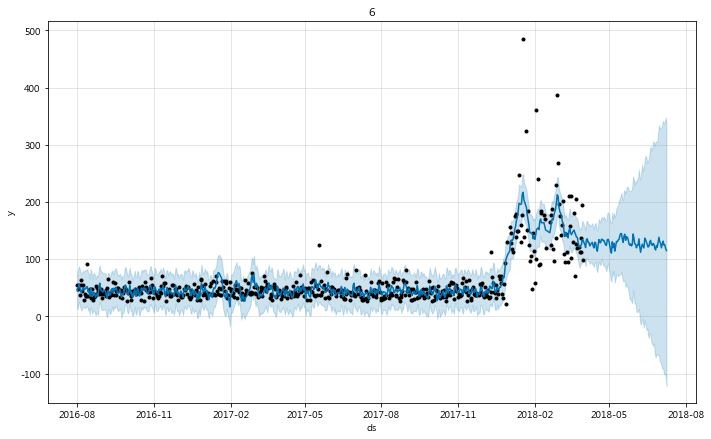

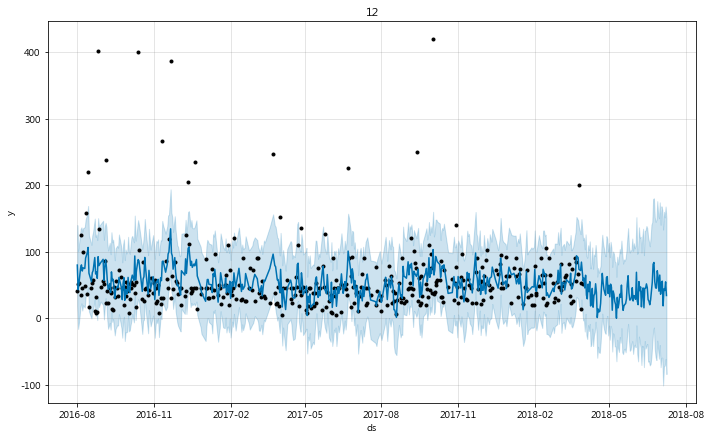

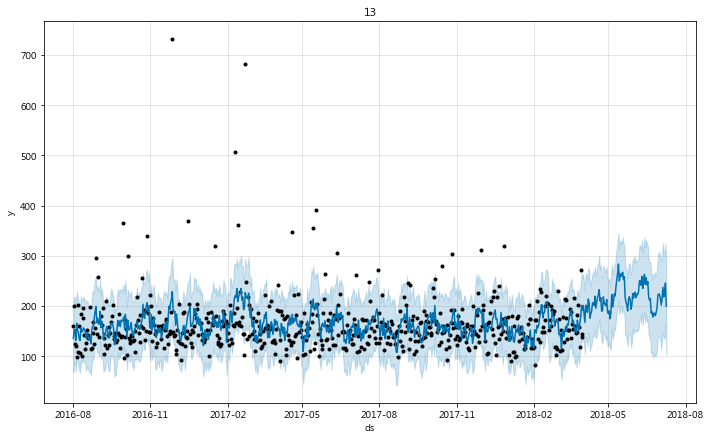

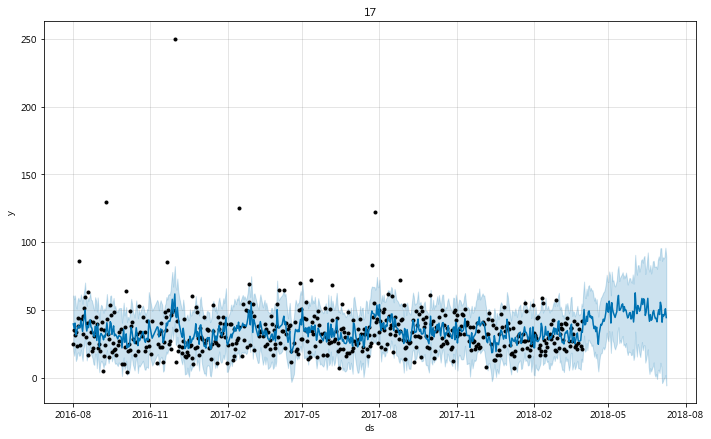

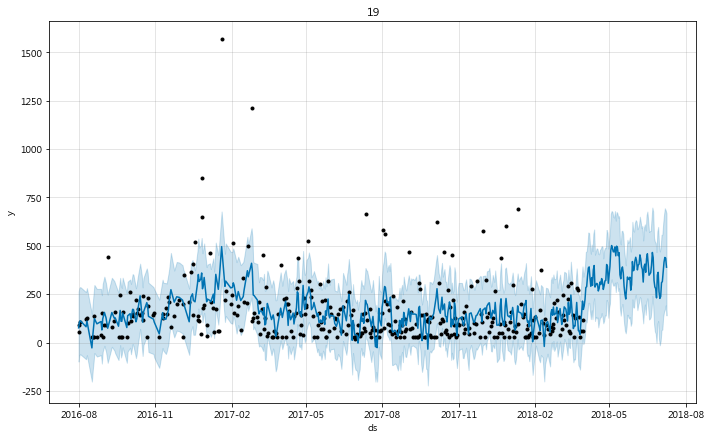

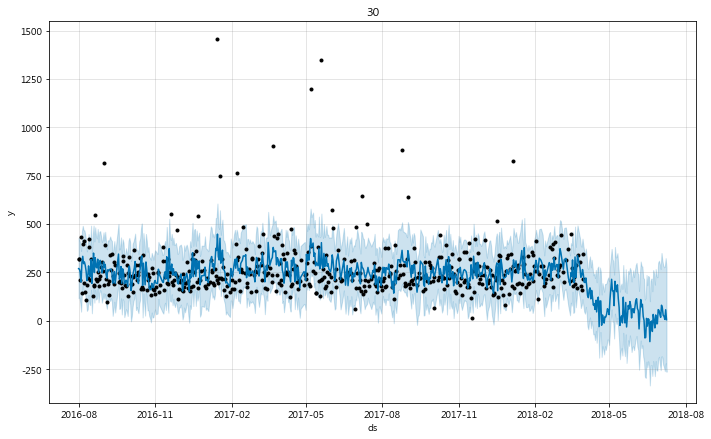

In [23]:
#하루로 묶어서 진행
#10개만 시각화 
train_grouped = new_test.groupby(['date','store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
store_ids = []
for i in tqdm(train_grouped.store_id.unique()[:10]):
    sample = train_grouped[train_grouped.store_id ==i]
    sample.drop('store_id',axis=1,inplace=True)
    
    if Train :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index= sample['date']
        sample.columns = ['ds','y']
        
        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.columns = ['ds','y']
        test= sample
    #예측
    m = Prophet(
                holidays=holidays,
                changepoint_prior_scale=10,
                changepoint_range = 0.5)

    m.add_seasonality(name='daily', period=1, fourier_order=15)
    m.add_seasonality(name='weekly',period=7, fourier_order=20)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
    m.add_seasonality(name='quarterly', period=365.25/4,fourier_order=5, prior_scale=15)
    m.add_seasonality(name='yearly',period=365.25, fourier_order=20)
    m.fit(test)
    
    future = m.make_future_dataframe(periods=100)    
    forecast = m.predict(future)   
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)
    store_ids.append(i)
    # 시각화부분
    fig1 = m.plot(forecast)
    plt.title(i)
    plt.show()


In [ ]:
#전체 진행
train_grouped = new_test.groupby(['date','store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
store_ids = []
for i in tqdm(train_grouped.store_id.unique()):
    sample = train_grouped[train_grouped.store_id ==i]
    sample.drop('store_id',axis=1,inplace=True)
    
    if Train :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index= sample['date']
        sample.columns = ['ds','y']
        
        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.columns = ['ds','y']
        test= sample
    #예측
    m = Prophet(
                holidays=holidays,
                changepoint_prior_scale=10,
                changepoint_range = 0.5)

    m.add_seasonality(name='daily', period=1, fourier_order=15)
    m.add_seasonality(name='weekly',period=7, fourier_order=20)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
    m.add_seasonality(name='quarterly', period=365.25/4,fourier_order=5, prior_scale=15)
    m.add_seasonality(name='yearly',period=365.25, fourier_order=20)
    m.fit(test)
    
    future = m.make_future_dataframe(periods=100)    
    forecast = m.predict(future)   
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)
    store_ids.append(i)
#     # 시각화부분
#     fig1 = m.plot(forecast)
#     plt.title(i)
#     plt.show()


In [13]:
result = pd.DataFrame(data={'store_id': store_ids, 'amount': y_preds}).sort_values('store_id')

In [19]:
submission['total_sales'] = result['amount']

In [21]:
today = datetime.datetime.today().date()
submission.to_csv(f'./submission/submission_{today}_fbprophet(0.01)_del_outlier_mean_rmse.csv',index=False)